In [19]:
%%capture
%run -i data_prep.ipynb

Index(['RowID', 'Year', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'TLRN', 'MotorwayNumber', 'Speed (kph)',
       'Length (m)', 'VehicleType', 'AADT', 'VKM'],
      dtype='object')
Index(['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Lts', 'Length (m)', 'Emissions', 'Year',
       'Pollutant', 'Emissions Unit', 'VehicleType', 'Emission Value'],
      dtype='object')


# Data analysis

In [20]:
# Define the file path and name
file_path = '../data/'
# merge_file_name = 'MajorRoadTrafficData.csv'
file_name = 'MajorRoadTrafficData.csv'

# file_path = '../data/MajorRoadTrafficData.csv'
df = pd.read_csv(file_path+file_name)

In [23]:
# Filter to target- CO2
df = df[df['Pollutant'] == 'CO2']

# Step 1: Handling Missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Step 2: Removing Duplicates
df = df.drop_duplicates()

Missing values in each column:
 Unnamed: 0              0
GridId                  0
Toid                    0
GRID_ExactCut_ID        0
Location_ExactCut       0
BoroughName_ExactCut    0
Lts                     0
Length (m)              0
Emissions               0
Year                    0
Pollutant               0
Emissions Unit          0
VehicleType             0
Emission Value          0
RowID                   0
TLRN                    0
MotorwayNumber          0
Speed (kph)             0
AADT                    0
VKM                     0
dtype: int64


In [25]:
# Step 3: Outlier Detection and Treatment using IQR method

numeric_df = df.select_dtypes(include=[np.number])

Q1 = numeric_df.quantile(0.25, numeric_only=True)
Q3 = numeric_df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Aligning DataFrame and IQR series for proper comparison
df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

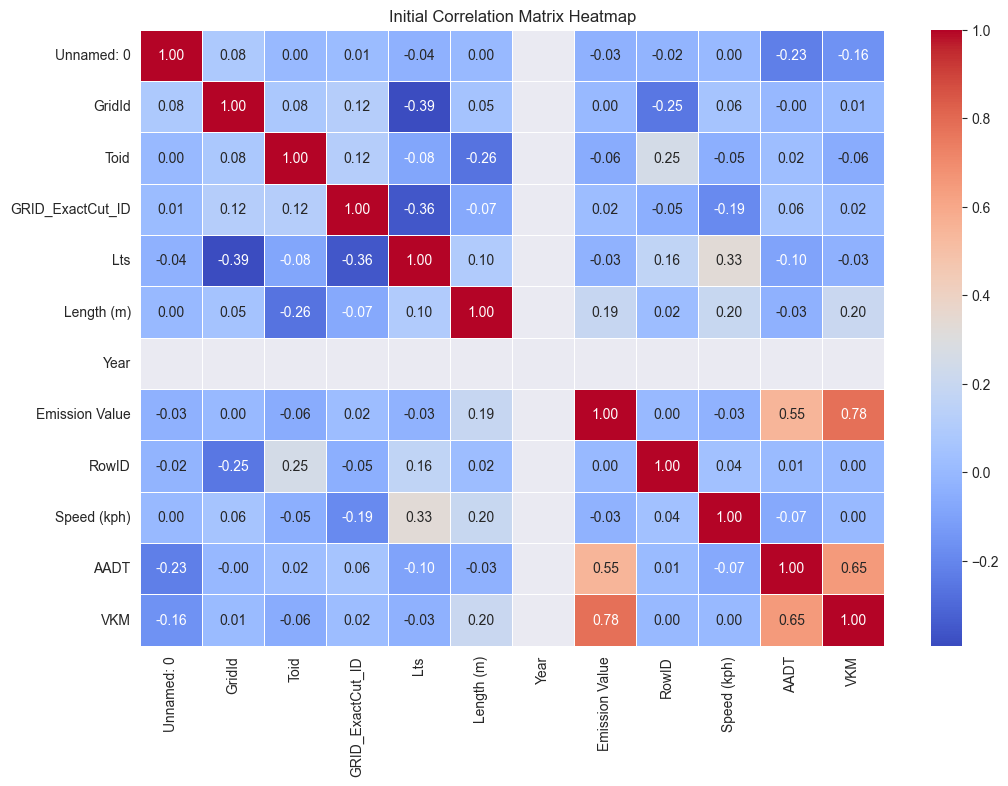

In [ ]:
# Filter numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Initial heatmap of the correlation matrix
initial_correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Initial Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Encode categorical variables
categorical_columns = ['Location_ExactCut', 'BoroughName_ExactCut', 'Emissions', 'TLRN', 'MotorwayNumber', 'Emissions Unit', 'VehicleType', 'Pollutant']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

# Calculate correlation matrix after encoding
encoded_correlation_matrix = df.corr()

# Correlation with the target variable
target_corr = encoded_correlation_matrix['Emission Value'].abs().sort_values(ascending=False)
print(target_corr)

# Select features with correlation greater than 0.05
selected_features = target_corr[target_corr > 0.05].index.tolist()
print(selected_features)
# # Add the target variable back to the selected features
selected_features.append('Emission Value')

df['Interaction_Length_Speed'] = df['Length (m)'] * df['Speed (kph)']
# df['Interaction_AADT_VKM'] = df['AADT'] * df['VKM']

# # Redefine features and preprocess again
# selected_features = selected_features + ['Interaction_Length_Speed', 'Interaction_AADT_VKM']
selected_features = selected_features + ['Interaction_Length_Speed']

# Plot final heatmap with Emission Value
final_correlation_matrix_with_target = df[selected_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap with Target')
plt.show()

In [ ]:
# Final dataset with selected features, drop 'Emission Value' for training features
X = df[selected_features].drop(columns=['Emission Value'])
y = df['Emission Value']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Print the final selected features
print(X_scaled_df.head())

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Final heatmap of the correlation matrix without the target
final_correlation_matrix = X_scaled_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap of Selected Features')
plt.show()

In [ ]:
# The dataset is now ready for ML training
dataset_info = {
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape,
    "features": selected_features[:-1],  # exclude the target from features
    "target": 'Emission Value'
}

print(dataset_info)